In [15]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

# Model 1 (trend)
# from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
import warnings

In [16]:
warnings.filterwarnings("ignore")

In [17]:
df_holidays = pd.read_csv('data/holidays_events.csv', header = 0)
df_oil = pd.read_csv('data/oil.csv', header = 0)
df_stores = pd.read_csv('data/stores.csv', header = 0)
df_trans = pd.read_csv('data/transactions.csv', header = 0)

df_train = pd.read_csv('data/train.csv', header = 0)
df_test = pd.read_csv('data/test.csv', header = 0)

In [18]:
#Converting all the date columns to pandas datetime format:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format = "%Y-%m-%d")

# Hybrid model for forecasting

In [19]:
# Hybrid model for forecasting
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

### Simple implementation of boosting ensemble learning

In [20]:
# we'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
         
    def fit(self, X_1, X_2, y):
        # train model_1
        self.model_1.fit(X_1, y)

        # make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )

        # compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid
    
    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()

In [21]:
family_sales.loc[:, 'sales']

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.092593,0.037037,0.055556,74.222222,0.000000,9.084685,0.129630,7.500000,11.518519,3.629167,...,0.074074,5.013167,2.629630,0.074074,0.222222,2.855537,1.040722,31.163778,0.000000,0.259259
2017-01-02,11.481481,0.259259,11.648148,6208.055556,0.481481,844.836296,14.203704,2233.648148,1545.000000,539.114833,...,7.777778,488.522332,714.370370,12.814815,22.777778,581.413130,153.555538,3409.500535,2.925926,33.581944
2017-01-03,8.296296,0.296296,7.185185,4507.814815,0.814815,665.124111,10.629630,1711.907407,1204.203704,404.300074,...,3.500000,427.520909,488.333333,8.870370,13.555556,462.013665,125.820537,3394.559756,2.018519,27.135259
2017-01-04,6.833333,0.333333,6.888889,3911.833333,0.759259,594.160611,11.185185,1508.037037,1107.796296,309.397685,...,3.500000,369.121482,426.574074,8.129630,12.092593,431.276409,116.740815,3467.447956,1.722222,22.034130
2017-01-05,6.333333,0.351852,5.925926,3258.796296,0.407407,495.511611,12.444444,1241.833333,829.277778,260.776500,...,3.203704,368.945687,360.925926,7.629630,10.333333,345.673499,101.434574,2069.316630,1.425926,20.615333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,8.166667,0.129630,6.500000,3502.055556,0.000000,522.305296,16.111111,1031.148148,831.648148,345.934963,...,9.259259,498.964667,295.888889,10.870370,12.111111,468.857370,96.286926,2198.854500,65.240741,23.566963
2017-08-12,7.462963,0.055556,6.833333,3376.259259,0.000000,507.473111,15.722222,1072.870370,793.592593,290.553574,...,8.944444,329.178706,294.500000,9.407407,13.185185,354.342779,84.693815,2070.154646,67.481481,19.037593
2017-08-13,8.907407,0.166667,8.018519,3747.296296,0.018519,615.976981,10.074074,1143.648148,928.000000,325.801371,...,8.685185,345.055834,336.814815,10.018519,13.722222,379.801204,91.509426,2331.922267,68.851852,20.704574


In [22]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [23]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor())

model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

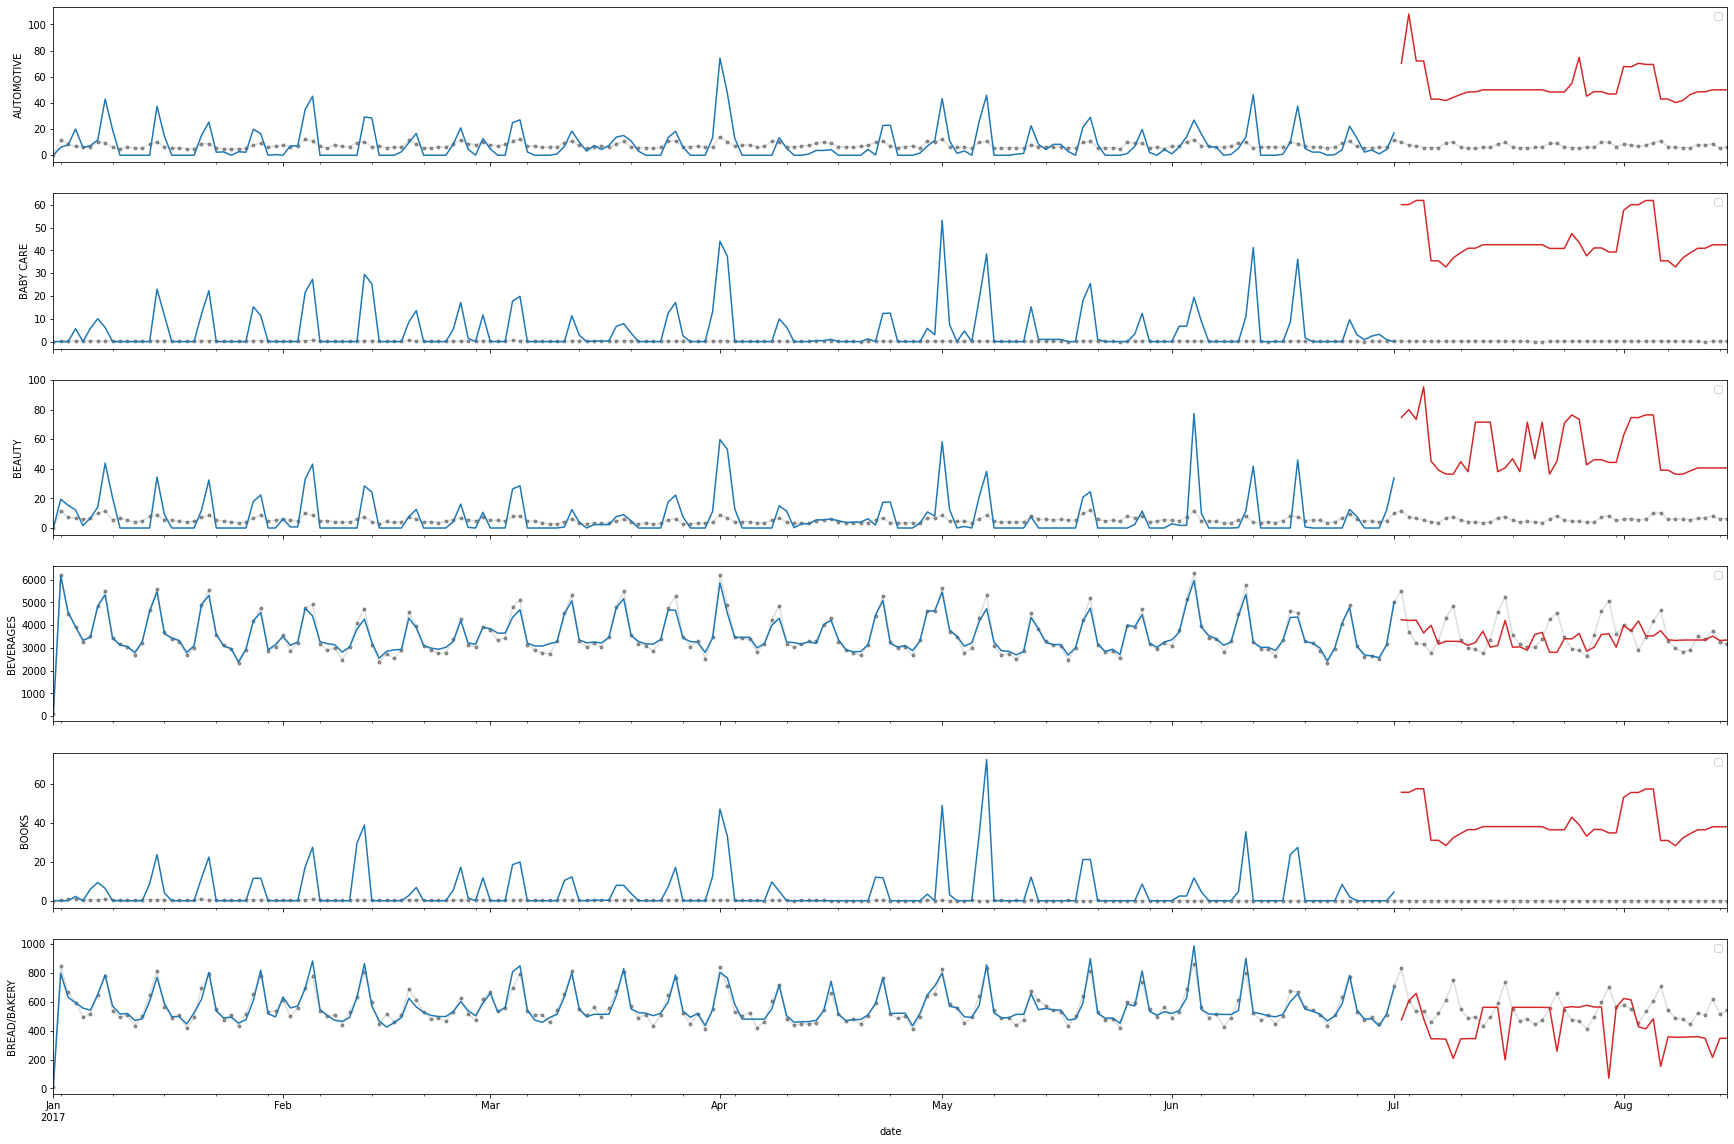

In [24]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization)
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(subplots=True, 
                                   sharex=True, 
                                   figsize=(30, 20), 
                                   color="0.75",
                                   style=".-",
                                   markeredgecolor="0.25",
                                   markerfacecolor="0.25",
                                   alpha=0.5)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

# Machine learning forcasting

In [25]:
# train data
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [26]:
# test data
test = df_test.copy()
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [27]:
def make_multistep_target(ts, steps):
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in range(steps)}, axis=1)

In [28]:
def make_lags(ts, lags):
    return pd.concat({f'y_lag_{i}': ts.shift(i) for i in range(1, lags + 1)}, axis=1)

In [29]:
y = family_sales.loc[:, 'sales']

# make 4 lag features
X = make_lags(y, lags=5).dropna()

# make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [30]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.018519    10.259259     9.388889   
           BABY CARE                      0.277778     0.259259     0.240741   
           BEAUTY                         6.518519    10.037037    11.611111   
           BEVERAGES                   3507.277778  4848.518519  5503.648148   
           BOOKS                          0.537037     0.481481     0.722222   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955648   403.601334   377.313980   
           PREPARED FOODS                84.698648    87.836796    88.735963   
           PRODUCE                     2257.140589  2609.180150  3122.895724   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333333    57.481481   
           SEAFOOD                       20.488333    20.346852    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.944444     4.777778     6.314815   
           BABY CARE                      0.444444     0.240741     0.277778   
           BEAUTY                         5.648148     6.500000     5.277778   
           BEVERAGES                   3448.203704  3171.740741  3046.870370   
           BOOKS                          0.500000     0.518519     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436093   533.497054   416.454018   
           PREPARED FOODS                77.173000    91.886760   100.384963   
           PRODUCE                     1792.220910  2079.319469  2418.970157   
           SCHOOL AND OFFICE SUPPLIES    51.907407    63.222222    85.203704   
           SEAFOOD                       17.116296    25.553963    24.209519   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.388889     5.240741     8.500000   
           BABY CARE                      0.296296     0.296296     0.388889   
           BEAUTY                         4.370370     4.703704     7.777778   
           BEVERAGES                   2693.722222  3226.037037  4667.296296   
           BOOKS                          0.388889     0.444444     0.574074   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596557   344.051740   313.780869   
           PREPARED FOODS               102.248148    86.627444    77.344130   
           PRODUCE                     2675.105815  2111.133423  2168.535465   
           SCHOOL AND OFFICE SUPPLIES   100.277778    64.407407    59.759259   
           SEAFOOD                       23.512852    18.419852    18.481130   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-06 AUTOMOTIVE                    10.259259     6.407407     5.685185   
           BABY CARE                      0.425926     0.314815     0.166667   
           BEAUTY                         9.037037     5.648148     5.351852   
           BEVERAGES                   5580.611111  3700.370370  3409.796296   
           BOOKS                          0.555556     0.388889     0.500000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270204   278.819870   468.857370   
           PREPARED FOODS                84.796537    78.791444    96.286926   
           PRODUCE                     2663.076241  1670.264889  2198.854500   
           SCHOOL AND OFFICE SUPPLIES  

In [31]:
# init model
model = RegressorChain(base_estimator=XGBRegressor())

In [32]:
# train model
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index,columns=y.columns).clip(0.0)


In [33]:
# helper function for plotting
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

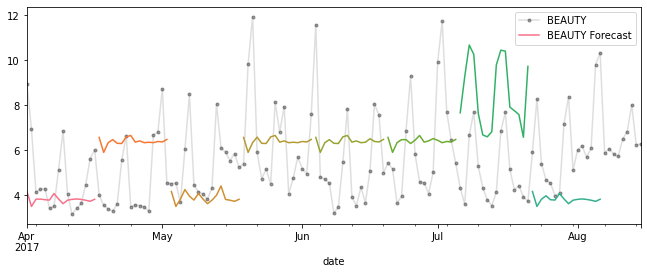

In [34]:
# plotting forcast with actual values
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])
